# Sentiment Analysis

In [4]:
import pandas as pd

df = pd.read_excel('financials/data.xlsx')

In [5]:
df.head()

,Title,Link,cardeyebrow,Date,Content
0,"First-time buyers targeted with £5,000 deposit...",https://www.ft.com/content/c36f4013-9aa0-48ad-...,UK property,yesterday,Mortgage brokers have welcomed an “innovative”...
1,China’s Vanke vows to cut debt by $14bn as pro...,https://www.ft.com/content/4c7d569f-f2b4-41fe-...,China Vanke Co Ltd,yesterday,"Vanke, one of China’s leading property develop..."
2,Retirement warning highlights fight over finan...,https://www.ft.com/content/22f3da76-931b-4a29-...,Pensions industry,yesterday,When BlackRock chief executive Larry Fink warn...
3,Are Thames Water investors ‘blackmailing’ Brit...,https://www.ft.com/content/0c1f86d6-c0fa-4b7c-...,UK companies,yesterday,One judgment to start: Sam Bankman-Fried has b...
4,UK property market shows hard-learned lessons ...,https://www.ft.com/content/f4ac9a0c-a424-4633-...,Lex,yesterday,The UK property sector has a proud tradition o...


Get the positive score for the content of the news using naive BERT model

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

# Define a dataset class
class NewsDataset(Dataset):
    def __init__(self, contents, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = contents
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten()
        }

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Assuming `data` is your DataFrame and 'Content' contains the text
contents = df['Content'].tolist()

# Create a dataset and dataloader
dataset = NewsDataset(contents, tokenizer)
dataloader = DataLoader(dataset, batch_size=16)

model.eval()  # Put model in evaluation mode
predictions = []

for batch in tqdm(dataloader):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    predictions += logits.tolist()

# `predictions` now contains the logits for each text, which can be further processed to derive sentiment


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 251/251 [21:34<00:00,  5.16s/it]


In [14]:
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(torch.tensor(predictions), dim=1)

# Assuming the model is trained for binary classification with [0: negative, 1: positive]
# Extract the probability of the article being positive
positive_scores = probabilities[:, 1]

# Convert to list for easier handling
positive_scores_list = positive_scores.tolist()

# Now, positive_scores_list contains the model's confidence that each article is positive
print(len(positive_scores_list))

4012


In [15]:
df['positive_score'] = positive_scores_list
df.to_csv('finace_sentiment.csv', index=False)

In [10]:
tokenizer.model_max_length - 2

1000000000000000019884624838654

# Using the pre-trained Finbert model to get the sentiment score

In [21]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from collections import Counter

tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, truncation=True, padding=True)

def process_content(content):
    tokens = tokenizer.tokenize(content)
    max_length = 512 - tokenizer.num_special_tokens_to_add()
    token_chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in token_chunks:
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        part_sentiment = nlp(chunk_text[0:513])

        sentiments.extend(part_sentiment)

    # Aggregate sentiments by majority voting
    label_counts = Counter([sentiment['label'] for sentiment in sentiments])
    most_common_label, _ = label_counts.most_common(1)[0]
    
    # Dynamically compute average scores for a more nuanced aggregation
    scores = {}
    for sentiment in sentiments:
        label = sentiment['label']
        if label in scores:
            scores[label] += sentiment['score']
        else:
            scores[label] = sentiment['score']
    
    for label in scores.keys():
        scores[label] /= len(token_chunks)
    print(scores)
    final_label = max(scores, key=scores.get)

    if final_label == 'Positive':
        value = 3
    elif final_label == 'Neutral':
        value = 2
    elif final_label == 'Negative':
        value = 1
    
    return {'label': final_label, 'score': scores[final_label], 'value' : value}

results = []
for content in df['Content']:
    processed_result = process_content(content)
    results.append(processed_result)

df['Sentiment'] = results
print(df.head())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'Neutral': 0.9870821833610535}
{'Negative': 0.9987625777721405}
{'Negative': 0.24999013543128967, 'Neutral': 0.7495389729738235}
{'Neutral': 0.6954645663499832, 'Negative': 0.13897529244422913}
{'Positive': 0.4996175169944763, 'Neutral': 0.49946466088294983}
{'Positive': 0.24999061226844788, 'Neutral': 0.7493709921836853}
{'Positive': 0.30839627981185913, 'Neutral': 0.49991655349731445}
{'Neutral': 0.9982622563838959}
{'Negative': 0.3277087410291036, 'Neutral': 0.5689080754915873}
{'Neutral': 0.7220723628997803}
{'Neutral': 0.39574486017227173, 'Negative': 0.47810137271881104}
{'Neutral': 0.8370106220245361}
{'Negative': 0.999932587146759}
{'Positive': 0.4999920725822449, 'Negative': 0.49699750542640686}
{'Neutral': 0.9320000648498535}
{'Neutral': 0.8155046999454498}
{'Negative': 0.49660199880599976, 'Neutral': 0.4985681176185608}
{'Neutral': 0.999904453754425}
{'Neutral': 0.9892032444477081}
{'Negative': 0.49964311718940735, 'Positive': 0.4999992847442627}
{'Negative': 0.333126465479

In [22]:
df.to_csv('finance_sentiment_Finbert1.csv', index=False)

# Data preprocess 
get the sentiment score, value and label for each article

In [17]:
import pandas as pd

df = pd.read_csv('finance_sentiment_Finbert1.csv')
df.head()

,Title,Link,cardeyebrow,Date,Content,Sentiment
0,"First-time buyers targeted with £5,000 deposit...",https://www.ft.com/content/c36f4013-9aa0-48ad-...,UK property,March 29 2024,Mortgage brokers have welcomed an “innovative”...,"{'label': 'Neutral', 'score': 0.98708218336105..."
1,China’s Vanke vows to cut debt by $14bn as pro...,https://www.ft.com/content/4c7d569f-f2b4-41fe-...,China Vanke Co Ltd,March 29 2024,"Vanke, one of China’s leading property develop...","{'label': 'Negative', 'score': 0.9987625777721..."
2,Retirement warning highlights fight over finan...,https://www.ft.com/content/22f3da76-931b-4a29-...,Pensions industry,March 29 2024,When BlackRock chief executive Larry Fink warn...,"{'label': 'Neutral', 'score': 0.74953897297382..."
3,Are Thames Water investors ‘blackmailing’ Brit...,https://www.ft.com/content/0c1f86d6-c0fa-4b7c-...,UK companies,March 29 2024,One judgment to start: Sam Bankman-Fried has b...,"{'label': 'Neutral', 'score': 0.69546456634998..."
4,UK property market shows hard-learned lessons ...,https://www.ft.com/content/f4ac9a0c-a424-4633-...,Lex,March 29 2024,The UK property sector has a proud tradition o...,"{'label': 'Positive', 'score': 0.4996175169944..."


In [18]:
import ast

# Replace NaN values in the 'Sentiment' column with a default dictionary
df['Sentiment'].fillna("{}", inplace=True)

# Convert the string representation of dictionaries in the 'Sentiment' column to actual dictionaries
df['Sentiment'] = df['Sentiment'].apply(lambda x: ast.literal_eval(x) if x != "{}" else {})

# Extract 'label', 'score', and 'value' keys into new columns
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: x.get('label', 'N/A'))
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: x.get('score', 0))
df['Sentiment_Value'] = df['Sentiment'].apply(lambda x: x.get('value', 'N/A'))

# Display the first few rows to verify the new columns
df.head()

,Title,Link,cardeyebrow,Date,Content,Sentiment,Sentiment_Label,Sentiment_Score,Sentiment_Value
0,"First-time buyers targeted with £5,000 deposit...",https://www.ft.com/content/c36f4013-9aa0-48ad-...,UK property,March 29 2024,Mortgage brokers have welcomed an “innovative”...,"{'label': 'Neutral', 'score': 0.98708218336105...",Neutral,0.987082,2
1,China’s Vanke vows to cut debt by $14bn as pro...,https://www.ft.com/content/4c7d569f-f2b4-41fe-...,China Vanke Co Ltd,March 29 2024,"Vanke, one of China’s leading property develop...","{'label': 'Negative', 'score': 0.9987625777721...",Negative,0.998763,1
2,Retirement warning highlights fight over finan...,https://www.ft.com/content/22f3da76-931b-4a29-...,Pensions industry,March 29 2024,When BlackRock chief executive Larry Fink warn...,"{'label': 'Neutral', 'score': 0.74953897297382...",Neutral,0.749539,2
3,Are Thames Water investors ‘blackmailing’ Brit...,https://www.ft.com/content/0c1f86d6-c0fa-4b7c-...,UK companies,March 29 2024,One judgment to start: Sam Bankman-Fried has b...,"{'label': 'Neutral', 'score': 0.69546456634998...",Neutral,0.695465,2
4,UK property market shows hard-learned lessons ...,https://www.ft.com/content/f4ac9a0c-a424-4633-...,Lex,March 29 2024,The UK property sector has a proud tradition o...,"{'label': 'Positive', 'score': 0.4996175169944...",Positive,0.499618,3


In [33]:
df['Sentiment_Value'] = df['Sentiment_Value'].replace('N/A', 0)
df['Sentiment_Score'] = pd.to_numeric(df['Sentiment_Score'])
df['Sentiment_Value'] = pd.to_numeric(df['Sentiment_Value'])
df['Sentiment_index'] = df['Sentiment_Score'] * df['Sentiment_Value']
# Assuming df is your DataFrame and 'Date' is the column containing the date values
df['Date'] = pd.to_datetime(df['Date'])
df.head()
df.to_csv('finance_sentiment_Finbert_clean.csv', index=False)

# Calculate the sentiment index for content in each day

In [1]:
import pandas as pd 

df = pd.read_csv('finance_sentiment_Finbert_clean.csv')
#df['Date'] = pd.to_datetime(df['Date'])
#df.to_csv('finance_sentiment_Finbert_clean.csv', index=False)

In [2]:
df.head()

,Title,Link,cardeyebrow,Date,Content,Sentiment,Sentiment_Label,Sentiment_Score,Sentiment_Value,Sentiment_index
0,"First-time buyers targeted with £5,000 deposit...",https://www.ft.com/content/c36f4013-9aa0-48ad-...,UK property,2024-03-29,Mortgage brokers have welcomed an “innovative”...,"{'label': 'Neutral', 'score': 0.98708218336105...",Neutral,0.987082,2.0,1.974164
1,China’s Vanke vows to cut debt by $14bn as pro...,https://www.ft.com/content/4c7d569f-f2b4-41fe-...,China Vanke Co Ltd,2024-03-29,"Vanke, one of China’s leading property develop...","{'label': 'Negative', 'score': 0.9987625777721...",Negative,0.998763,1.0,0.998763
2,Retirement warning highlights fight over finan...,https://www.ft.com/content/22f3da76-931b-4a29-...,Pensions industry,2024-03-29,When BlackRock chief executive Larry Fink warn...,"{'label': 'Neutral', 'score': 0.74953897297382...",Neutral,0.749539,2.0,1.499078
3,Are Thames Water investors ‘blackmailing’ Brit...,https://www.ft.com/content/0c1f86d6-c0fa-4b7c-...,UK companies,2024-03-29,One judgment to start: Sam Bankman-Fried has b...,"{'label': 'Neutral', 'score': 0.69546456634998...",Neutral,0.695465,2.0,1.390929
4,UK property market shows hard-learned lessons ...,https://www.ft.com/content/f4ac9a0c-a424-4633-...,Lex,2024-03-29,The UK property sector has a proud tradition o...,"{'label': 'Positive', 'score': 0.4996175169944...",Positive,0.499618,3.0,1.498853


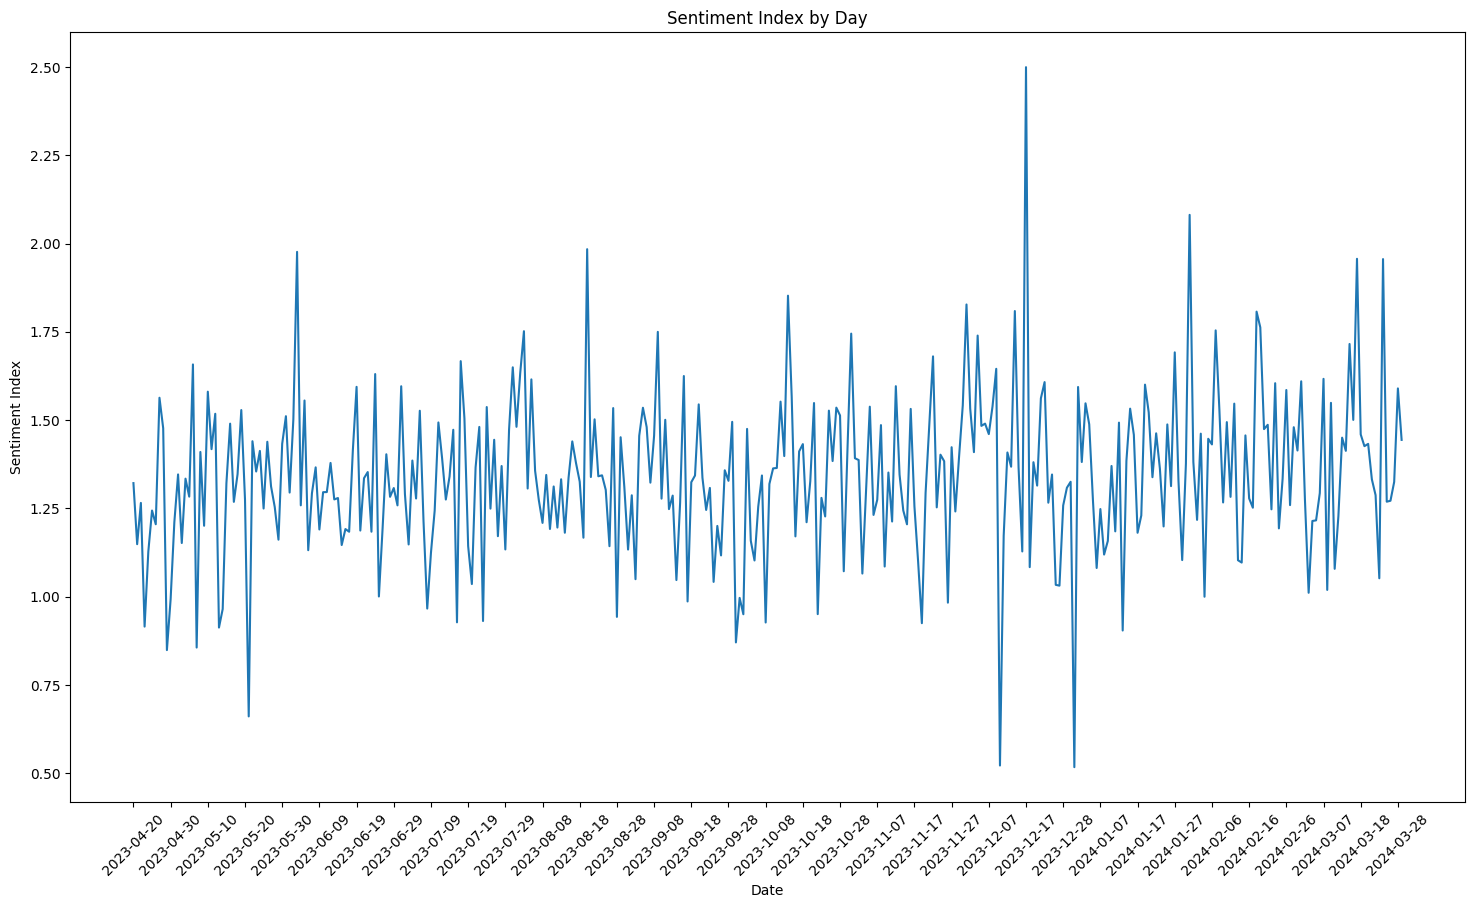

In [58]:
import matplotlib.pyplot as plt

sentiment_index_by_day = df.groupby('Date')['Sentiment_index'].mean()

# Plotting the sentiment index by day
plt.figure(figsize=(18, 10))
plt.plot(sentiment_index_by_day.index, sentiment_index_by_day.values)
plt.xlabel('Date')
plt.ylabel('Sentiment Index')
plt.title('Sentiment Index by Day')
plt.xticks(rotation=45)
plt.xticks(range(0, len(sentiment_index_by_day.index), 10), sentiment_index_by_day.index[::10])
plt.show()

sentiment_index_by_day.to_csv('sentiment_index_by_day.csv')



# Get the title sentiment

In [4]:
def process_content(content):
    tokens = tokenizer.tokenize(content)
    max_length = 512 - tokenizer.num_special_tokens_to_add()
    token_chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in token_chunks:
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        part_sentiment = nlp(chunk_text[0:513])

        sentiments.extend(part_sentiment)

    # Aggregate sentiments by majority voting
    label_counts = Counter([sentiment['label'] for sentiment in sentiments])
    most_common_label, _ = label_counts.most_common(1)[0]
    
    # Dynamically compute average scores for a more nuanced aggregation
    scores = {}
    for sentiment in sentiments:
        label = sentiment['label']
        if label in scores:
            scores[label] += sentiment['score']
        else:
            scores[label] = sentiment['score']
    
    for label in scores.keys():
        scores[label] /= len(token_chunks)
    print(scores)
    final_label = max(scores, key=scores.get)

    if final_label == 'Positive':
        value = 3
    elif final_label == 'Neutral':
        value = 2
    elif final_label == 'Negative':
        value = 1
    
    return {'label': final_label, 'score': scores[final_label], 'value' : value}

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from collections import Counter

tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, truncation=True, padding=True)
results = []
for content in df['Title'].astype(str):  # Convert 'Title' column values to strings
    processed_result = process_content(content)
    results.append(processed_result)

df['Sentiment_title'] = results
print(df.head())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'Neutral': 0.9999969005584717}
{'Neutral': 0.8458633422851562}
{'Negative': 0.9822092056274414}
{'Neutral': 0.9994757771492004}
{'Positive': 0.9998798370361328}
{'Neutral': 0.9189821481704712}
{'Neutral': 0.9922286868095398}
{'Neutral': 0.9933373928070068}
{'Neutral': 0.9969244599342346}
{'Neutral': 0.9999703168869019}
{'Positive': 0.9950533509254456}
{'Neutral': 0.9971712231636047}
{'Negative': 0.999722421169281}
{'Positive': 0.9998511075973511}
{'Neutral': 0.9173257946968079}
{'Negative': 0.7548601031303406}
{'Negative': 0.9993876218795776}
{'Neutral': 0.9999992847442627}
{'Neutral': 0.9998797178268433}
{'Negative': 0.9997984766960144}
{'Negative': 0.9999545812606812}
{'Neutral': 0.9988105297088623}
{'Neutral': 0.9997567534446716}
{'Neutral': 0.9995701909065247}
{'Neutral': 0.6042927503585815}
{'Neutral': 0.999062716960907}
{'Negative': 0.9763730764389038}
{'Negative': 0.9999233484268188}
{'Neutral': 0.9993396401405334}
{'Negative': 0.9999278783798218}
{'Neutral': 0.9998353719711304

In [10]:
import ast

# Replace NaN values in the 'Sentiment' column with a default dictionary
df['Sentiment_title'].fillna("{}", inplace=True)

# Convert the string representation of dictionaries in the 'Sentiment' column to actual dictionaries
#df['Sentiment_title'] = df['Sentiment_title'].apply(lambda x: ast.literal_eval(x) if x != "{}" else {})

# Extract 'label', 'score', and 'value' keys into new columns
df['Sentiment_Label'] = df['Sentiment_title'].apply(lambda x: x.get('label', 'N/A'))
df['Sentiment_Score'] = df['Sentiment_title'].apply(lambda x: x.get('score', 0))
df['Sentiment_Value'] = df['Sentiment_title'].apply(lambda x: x.get('value', 'N/A'))


In [11]:
df.head()

,Title,Link,cardeyebrow,Date,Content,Sentiment,Sentiment_Label,Sentiment_Score,Sentiment_Value,Sentiment_index,Sentiment_title
0,"First-time buyers targeted with £5,000 deposit...",https://www.ft.com/content/c36f4013-9aa0-48ad-...,UK property,2024-03-29,Mortgage brokers have welcomed an “innovative”...,"{'label': 'Neutral', 'score': 0.98708218336105...",Neutral,0.999997,2,1.974164,"{'label': 'Neutral', 'score': 0.99999690055847..."
1,China’s Vanke vows to cut debt by $14bn as pro...,https://www.ft.com/content/4c7d569f-f2b4-41fe-...,China Vanke Co Ltd,2024-03-29,"Vanke, one of China’s leading property develop...","{'label': 'Negative', 'score': 0.9987625777721...",Neutral,0.845863,2,0.998763,"{'label': 'Neutral', 'score': 0.84586334228515..."
2,Retirement warning highlights fight over finan...,https://www.ft.com/content/22f3da76-931b-4a29-...,Pensions industry,2024-03-29,When BlackRock chief executive Larry Fink warn...,"{'label': 'Neutral', 'score': 0.74953897297382...",Negative,0.982209,1,1.499078,"{'label': 'Negative', 'score': 0.9822092056274..."
3,Are Thames Water investors ‘blackmailing’ Brit...,https://www.ft.com/content/0c1f86d6-c0fa-4b7c-...,UK companies,2024-03-29,One judgment to start: Sam Bankman-Fried has b...,"{'label': 'Neutral', 'score': 0.69546456634998...",Neutral,0.999476,2,1.390929,"{'label': 'Neutral', 'score': 0.99947577714920..."
4,UK property market shows hard-learned lessons ...,https://www.ft.com/content/f4ac9a0c-a424-4633-...,Lex,2024-03-29,The UK property sector has a proud tradition o...,"{'label': 'Positive', 'score': 0.4996175169944...",Positive,0.999880,3,1.498853,"{'label': 'Positive', 'score': 0.9998798370361..."


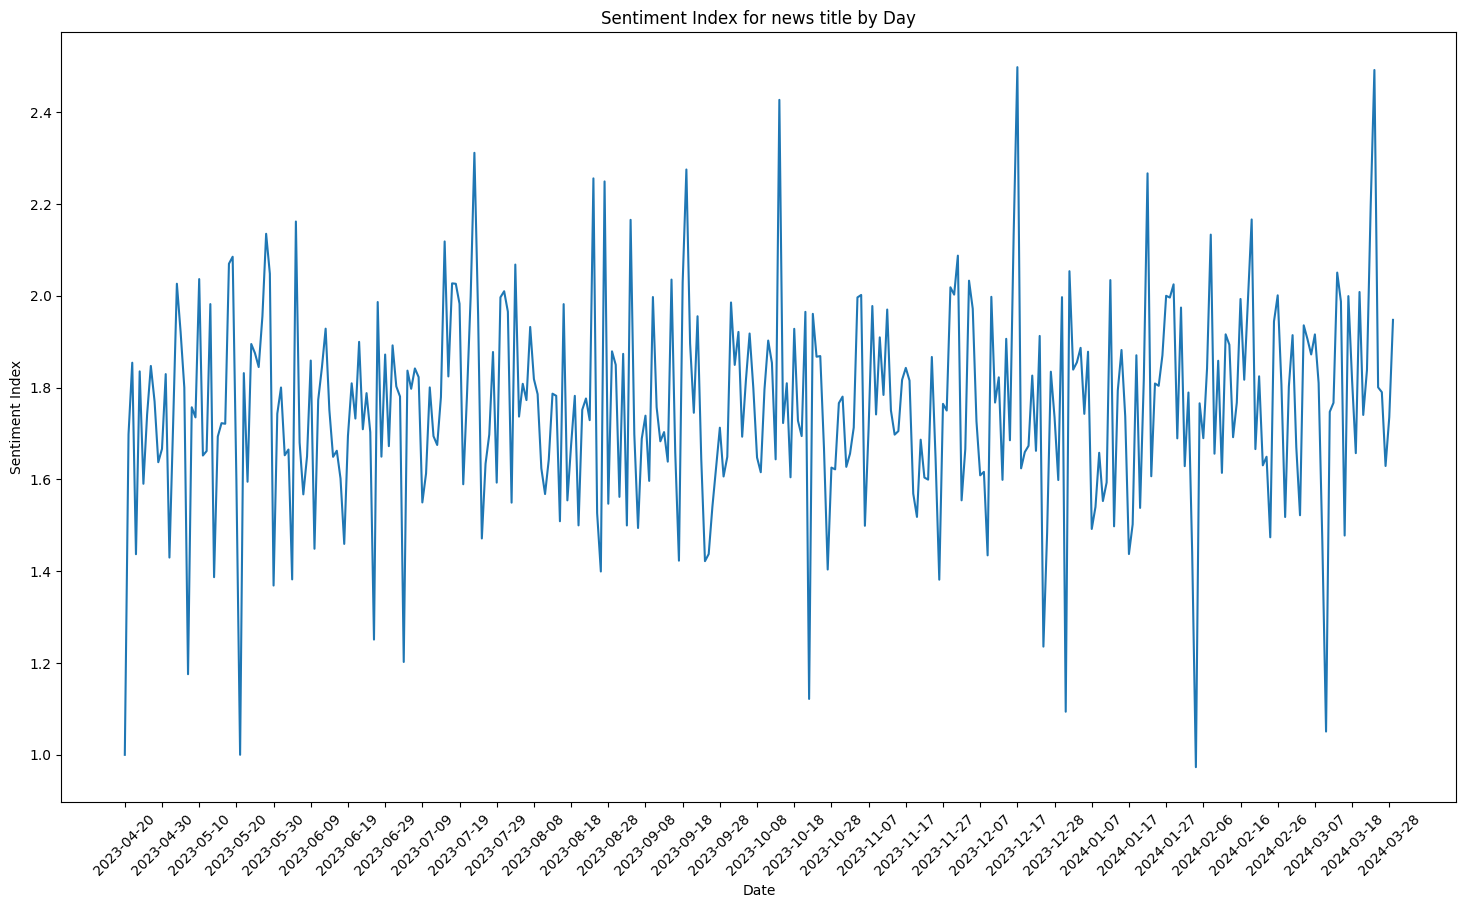

In [13]:
df['Sentiment_index'] = df['Sentiment_Score'] * df['Sentiment_Value']

import matplotlib.pyplot as plt

sentiment_index_title_by_day = df.groupby('Date')['Sentiment_index'].mean()

# Plotting the sentiment index by day
plt.figure(figsize=(18, 10))
plt.plot(sentiment_index_title_by_day.index, sentiment_index_title_by_day.values)
plt.xlabel('Date')
plt.ylabel('Sentiment Index')
plt.title('Sentiment Index for news title by Day')
plt.xticks(rotation=45)
plt.xticks(range(0, len(sentiment_index_title_by_day.index), 10), sentiment_index_title_by_day.index[::10])
plt.show()

sentiment_index_title_by_day.to_csv('sentiment_index_title_by_day.csv')

# Company Specific data

count the occurrence of each company

In [18]:
companyList = ["Caterpillar", "General Electric", "Honeywell", "Lockheed Martin", "Deere", "Delta Air Lines", "Union Pacific", "FedEx", "Raytheon Technologies", "JPMorgan", "Bank of America", "Wells Fargo", "Citigroup", "Goldman Sachs", "Morgan Stanley", "American Express", "Charles Schwab", "BlackRock", "Apple", "Microsoft", "Google", "NVIDIA", "Visa", "Mastercard", "Intel", "Adobe", "Salesforce", "Oracle"]
for i in companyList:
    count = (df['Title'].str.contains(i)).sum()
    print(i, ":", count)

Caterpillar : 0
General Electric : 0
Honeywell : 0
Lockheed Martin : 0
Deere : 0
Delta Air Lines : 0
Union Pacific : 0
FedEx : 0
Raytheon Technologies : 0
JPMorgan : 62
Bank of America : 6
Wells Fargo : 7
Citigroup : 11
Goldman Sachs : 55
Morgan Stanley : 37
American Express : 1
Charles Schwab : 2
BlackRock : 42
Apple : 4
Microsoft : 4
Google : 2
NVIDIA : 0
Visa : 6
Mastercard : 9
Intel : 0
Adobe : 0
Salesforce : 0
Oracle : 0


filter the data with title contains the name of these company

In [25]:
processedCompanyList = ["JPMorgan", "Bank of America", "Wells Fargo", "Citigroup", "Goldman Sachs", "Morgan Stanley", "American Express", "Charles Schwab", "BlackRock", "Apple", "Microsoft", "Visa", "Mastercard"]

filtered_df = df[df['Title'].apply(lambda x: any(name in x for name in processedCompanyList))]
filtered_df.head()

,Title,Link,cardeyebrow,Date,Content,Sentiment,Sentiment_Label,Sentiment_Score,Sentiment_Value,Sentiment_index,Sentiment_title
17,BlackRock rolls out its first active equity ET...,https://www.ft.com/content/c0e2f9a7-5ab6-4d8c-...,Exchange traded funds,2024-03-28,Visit our ETF Hub to find out more and to expl...,"{'label': 'Neutral', 'score': 0.99990445375442...",Neutral,0.999999,2,1.999999,"{'label': 'Neutral', 'score': 0.99999928474426..."
22,Visa and Mastercard’s deal to cut fees is a ho...,https://www.ft.com/content/0208fbcc-804f-427a-...,Lex,2024-03-28,"Paying for everyday transactions with a tap, s...","{'label': 'Neutral', 'score': 0.99312976002693...",Neutral,0.999757,2,1.999514,"{'label': 'Neutral', 'score': 0.99975675344467..."
37,Visa and Mastercard agree $30bn settlement ove...,https://www.ft.com/content/7fd67b7a-fa87-449c-...,Credit cards,2024-03-26,Visa and Mastercard have agreed to cut their U...,"{'label': 'Neutral', 'score': 0.48888295888900...",Neutral,0.999972,2,1.999945,"{'label': 'Neutral', 'score': 0.99997246265411..."
66,US investment funds pull $13.3bn from BlackRoc...,https://www.ft.com/content/9306c8f2-530d-45ca-...,ESG investing,2024-03-24,Nearly two years into a Republican campaign to...,"{'label': 'Neutral', 'score': 0.99478289484977...",Neutral,0.999948,2,1.999896,"{'label': 'Neutral', 'score': 0.99994778633117..."
77,How Stephanie Cohen went from ‘all in on Goldm...,https://www.ft.com/content/920d39f4-f514-40c7-...,Goldman Sachs Group,2024-03-22,When Stephanie Cohen joined Goldman Sachs righ...,"{'label': 'Neutral', 'score': 0.49922251701354...",Neutral,0.999769,2,1.999538,"{'label': 'Neutral', 'score': 0.99976891279220..."


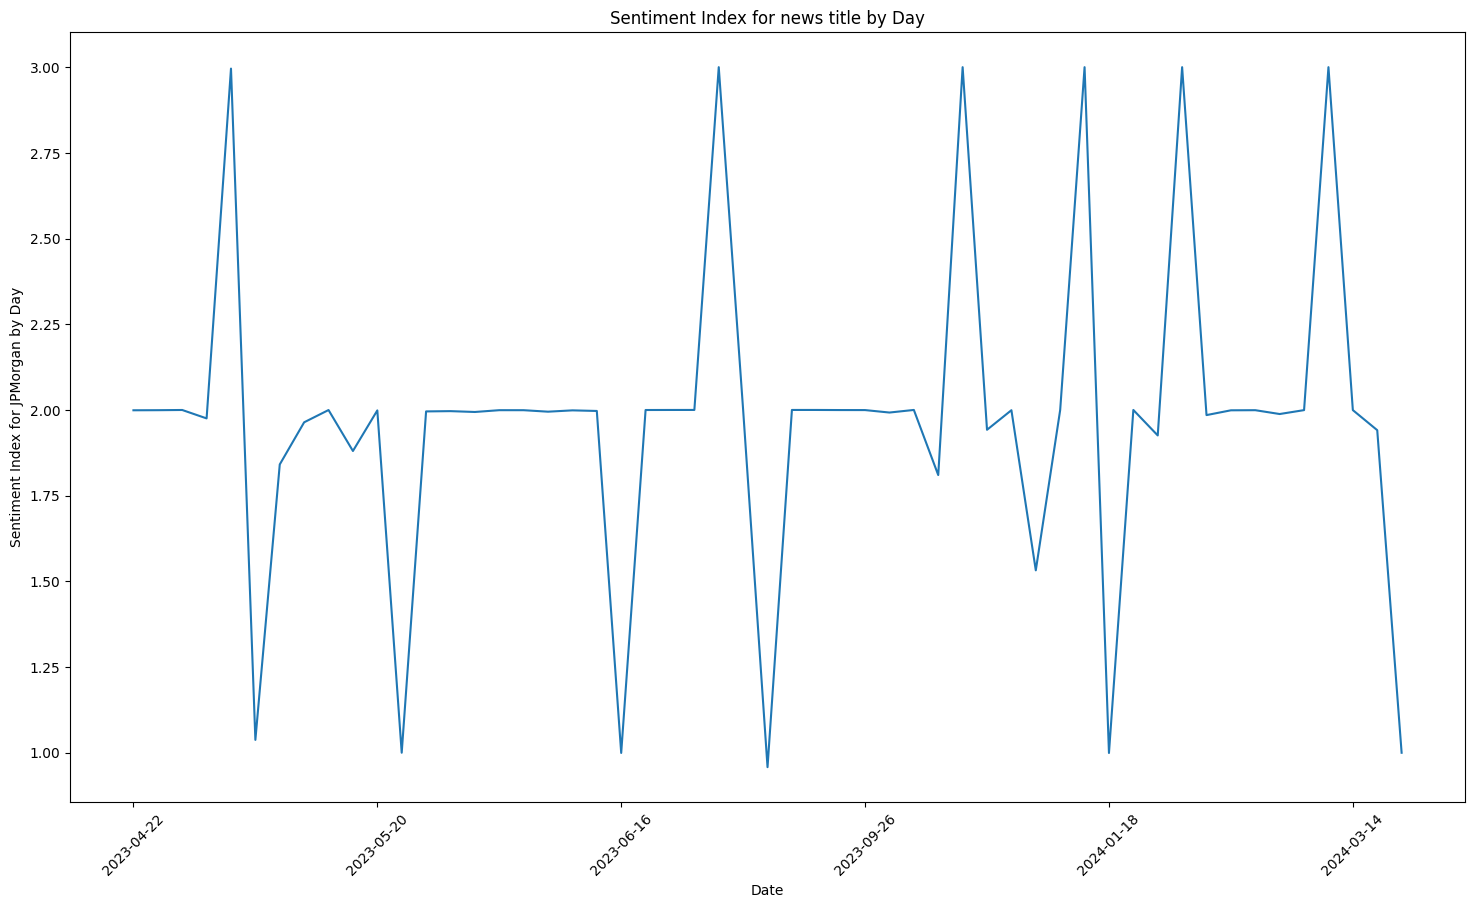

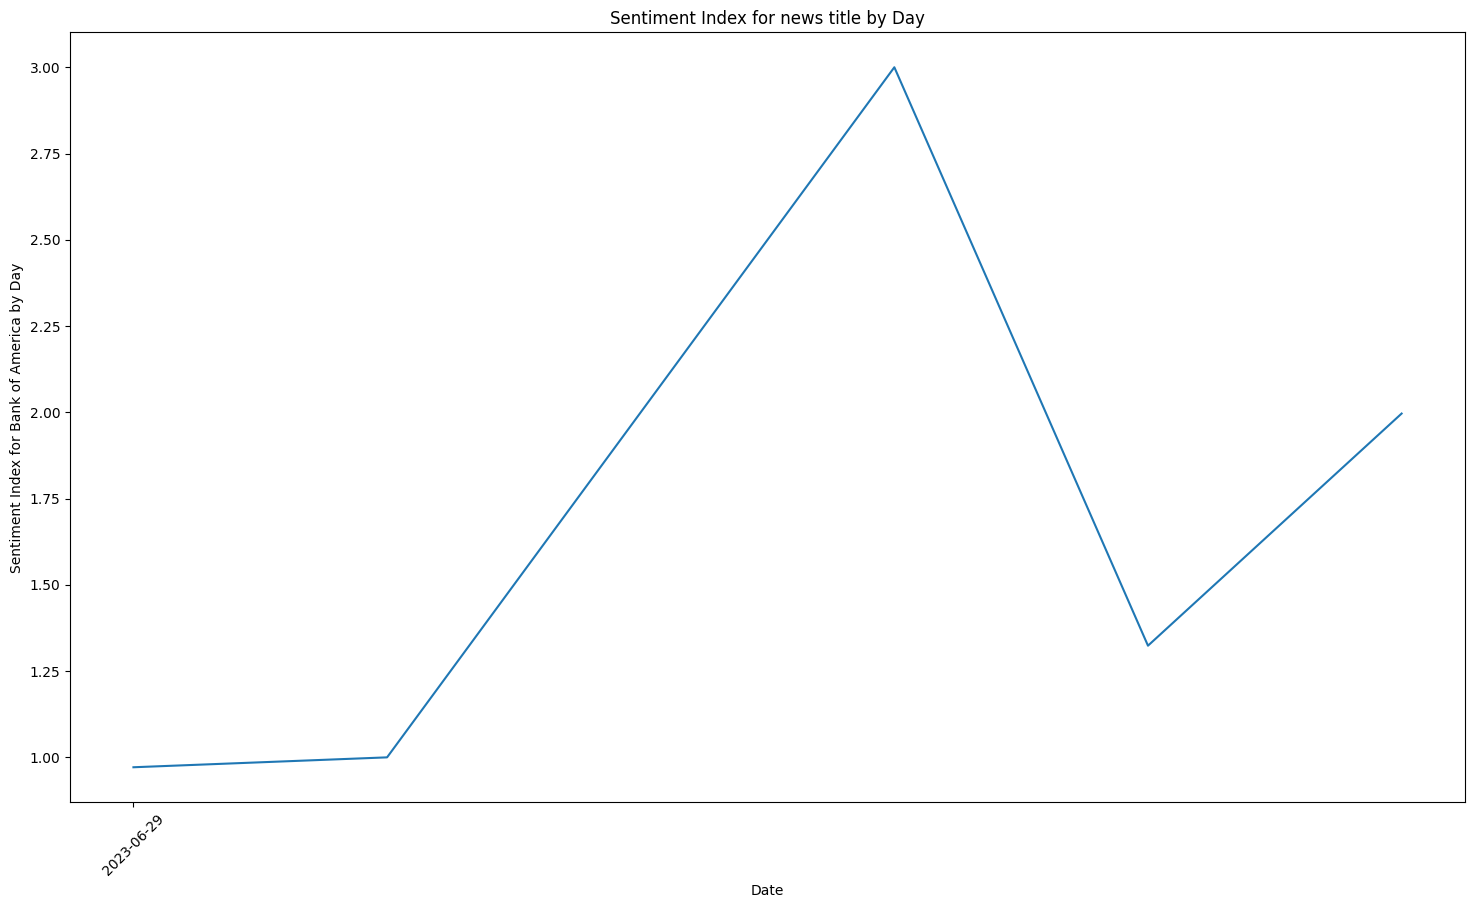

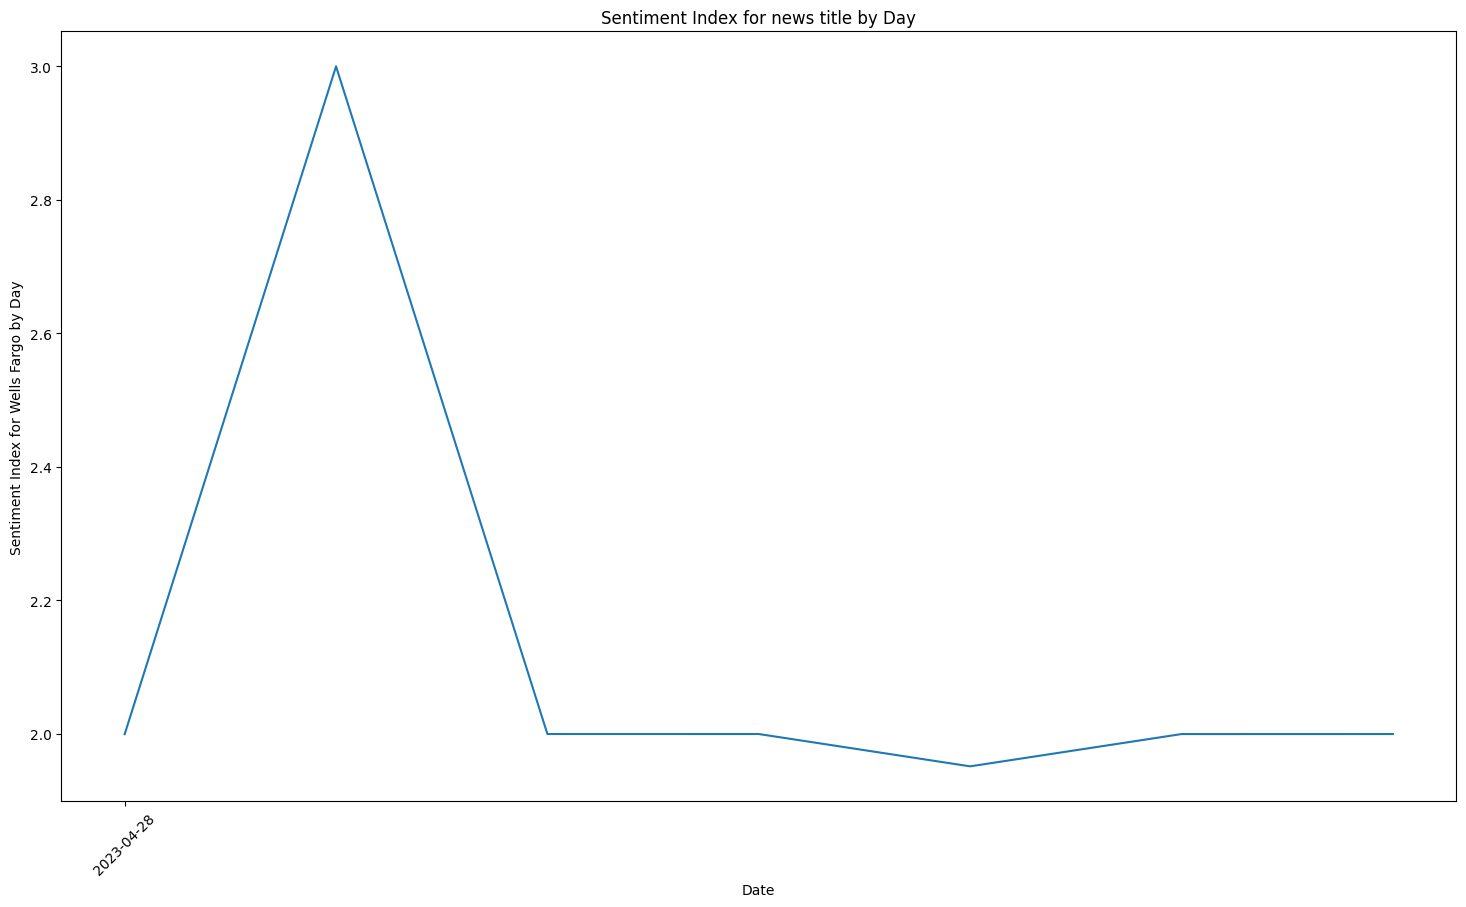

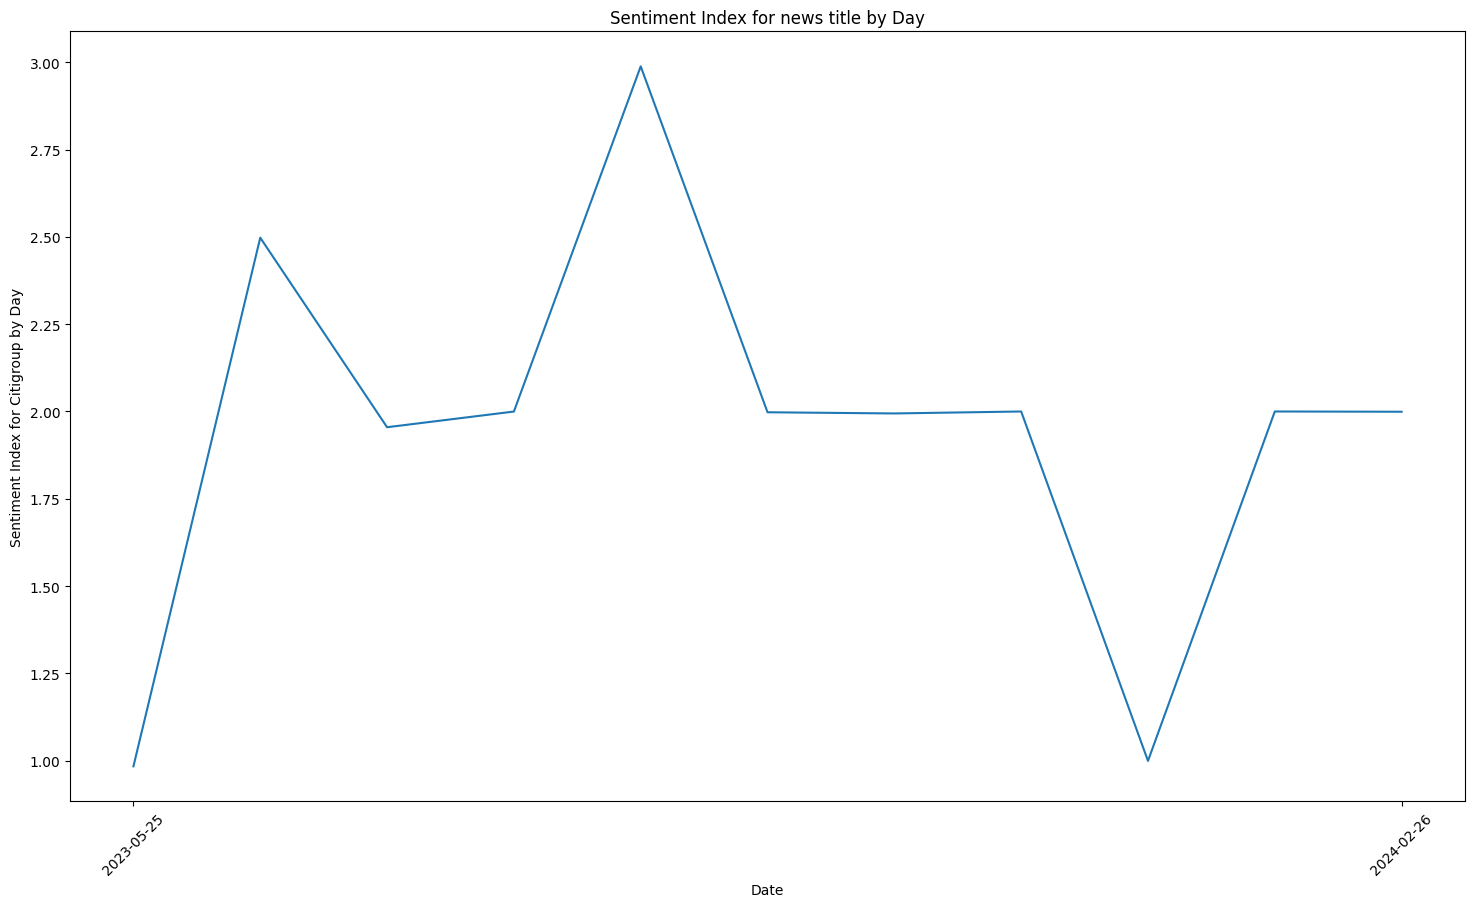

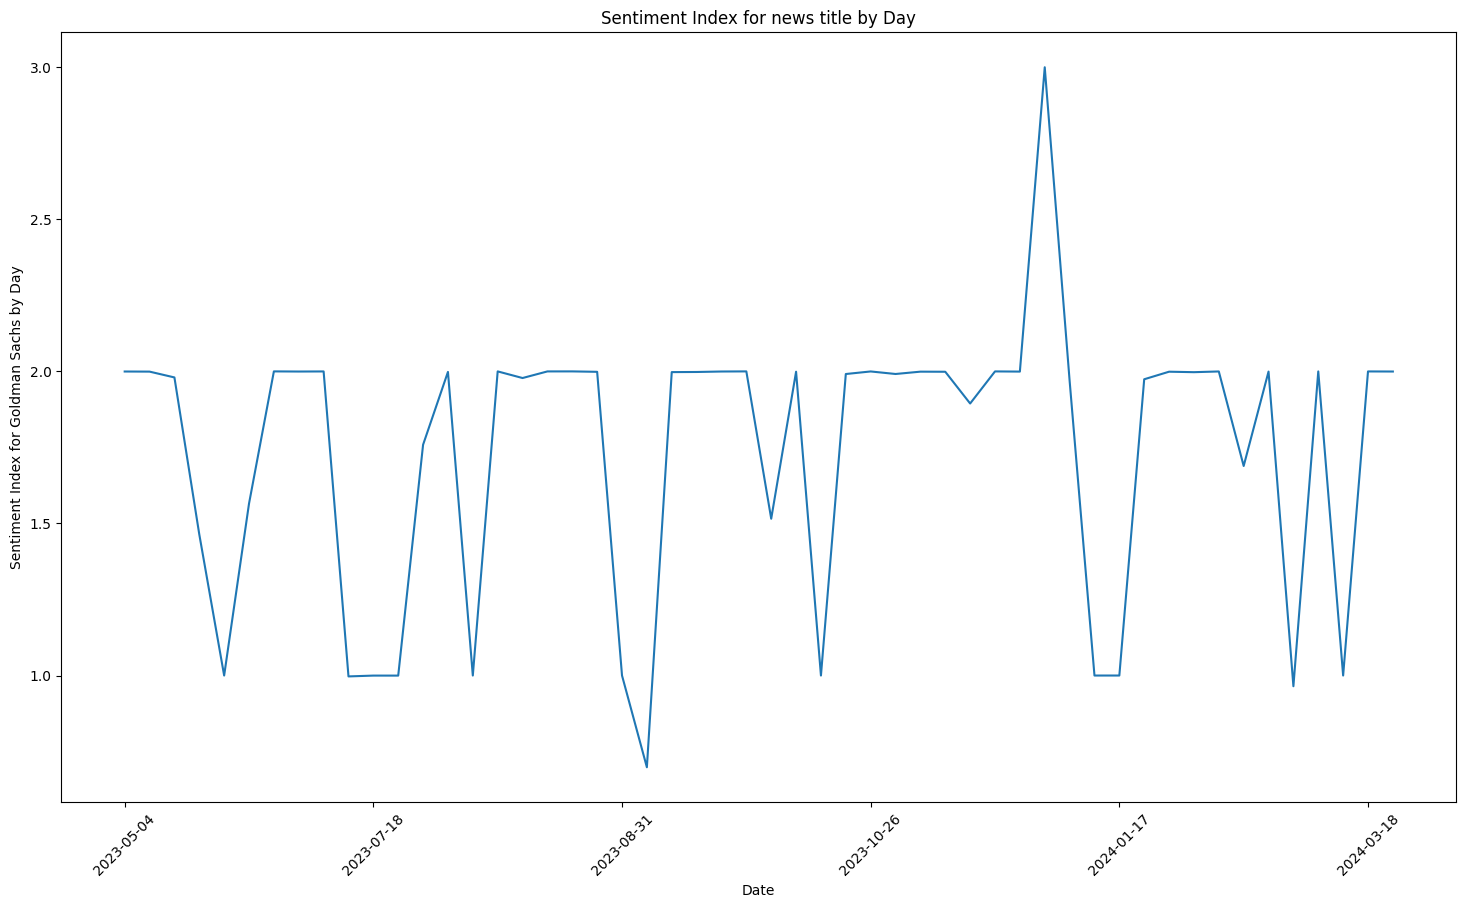

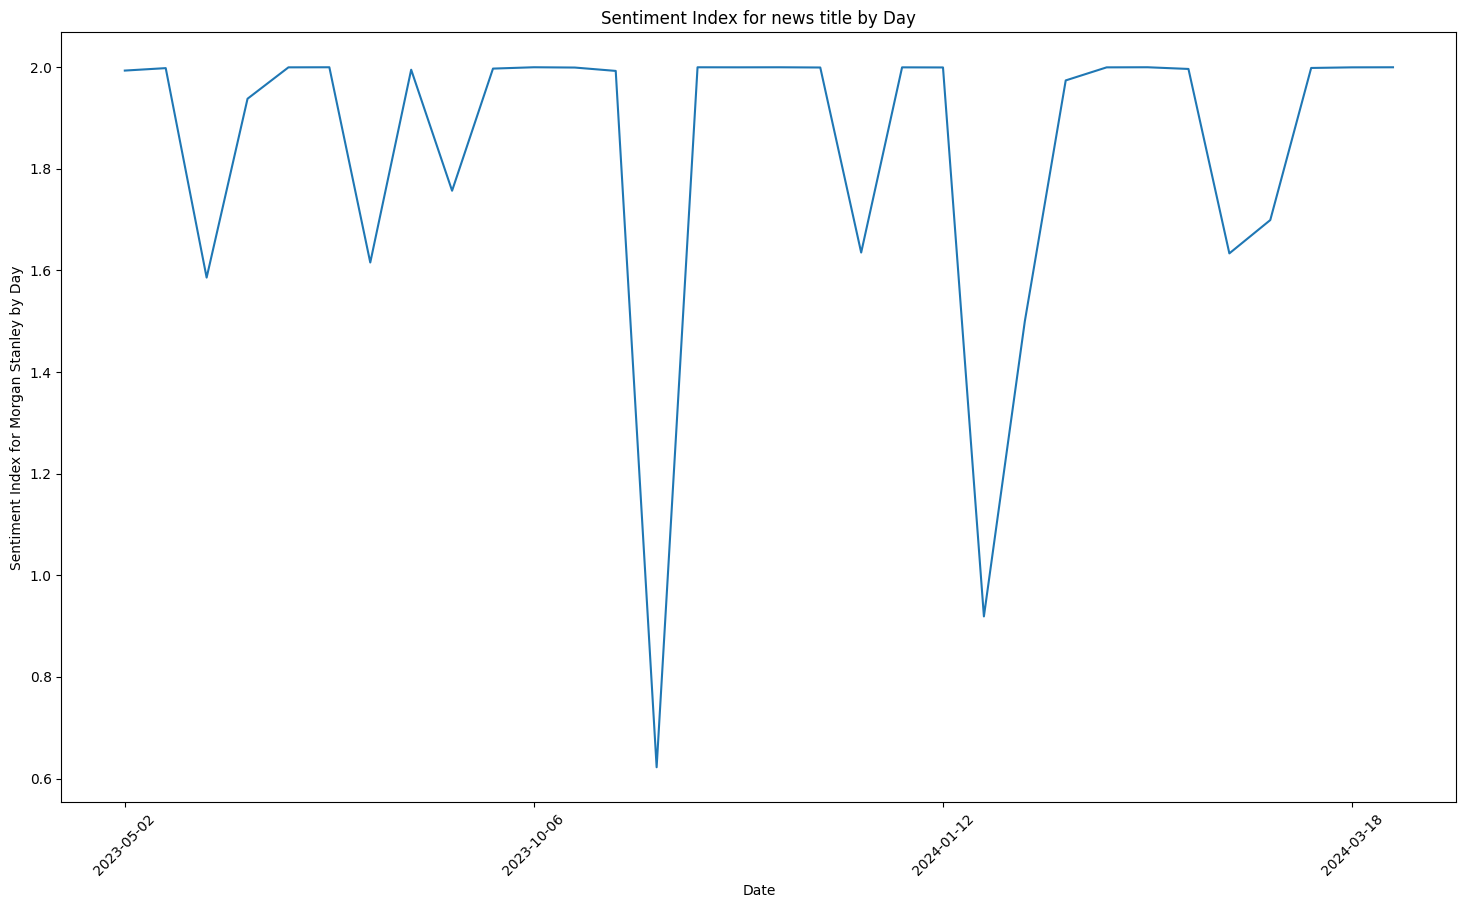

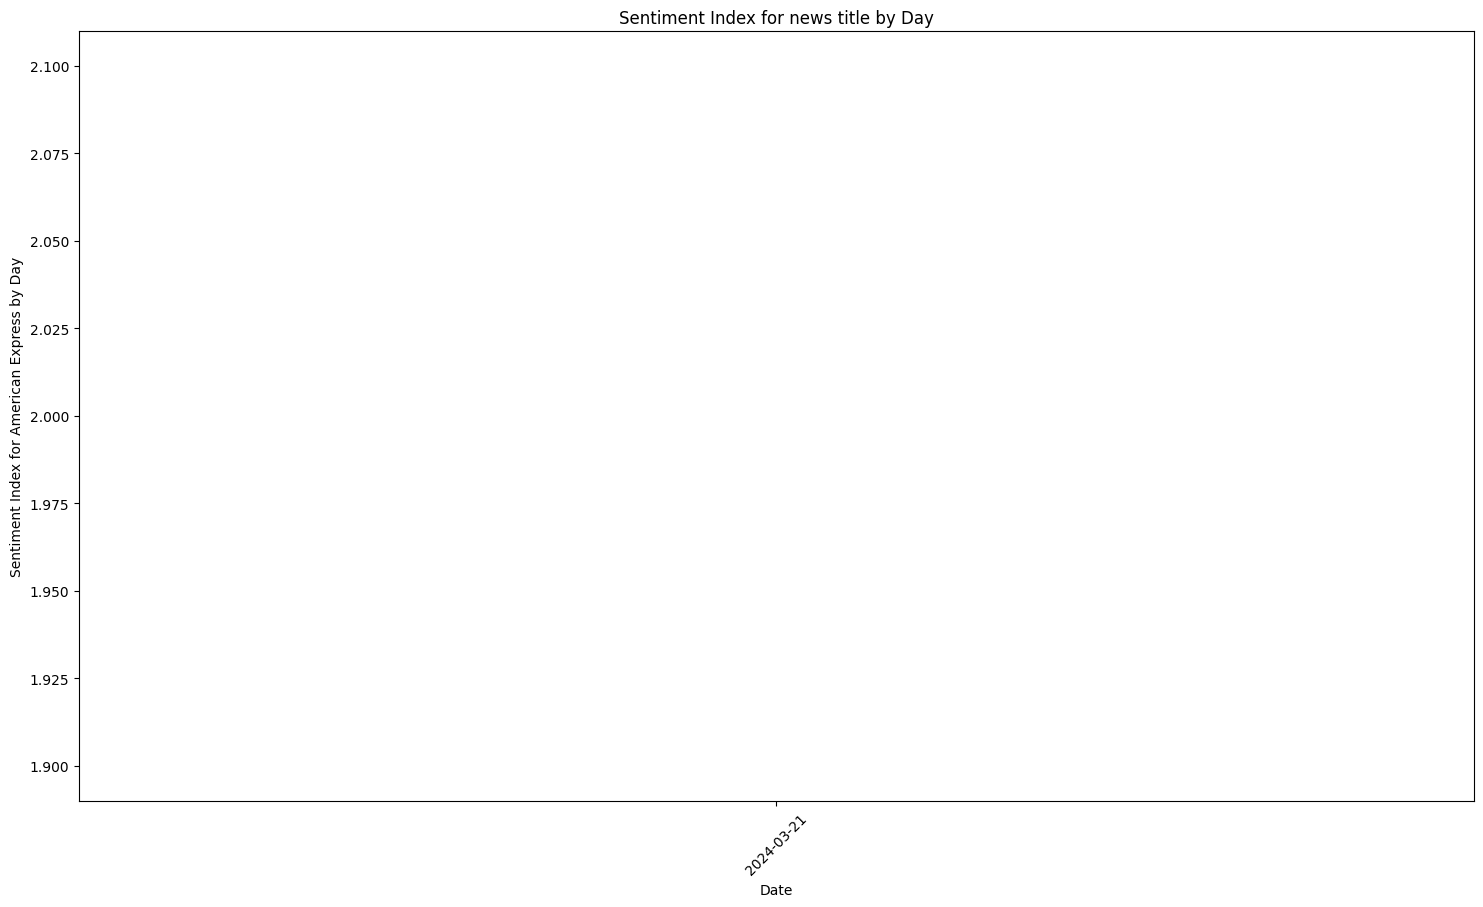

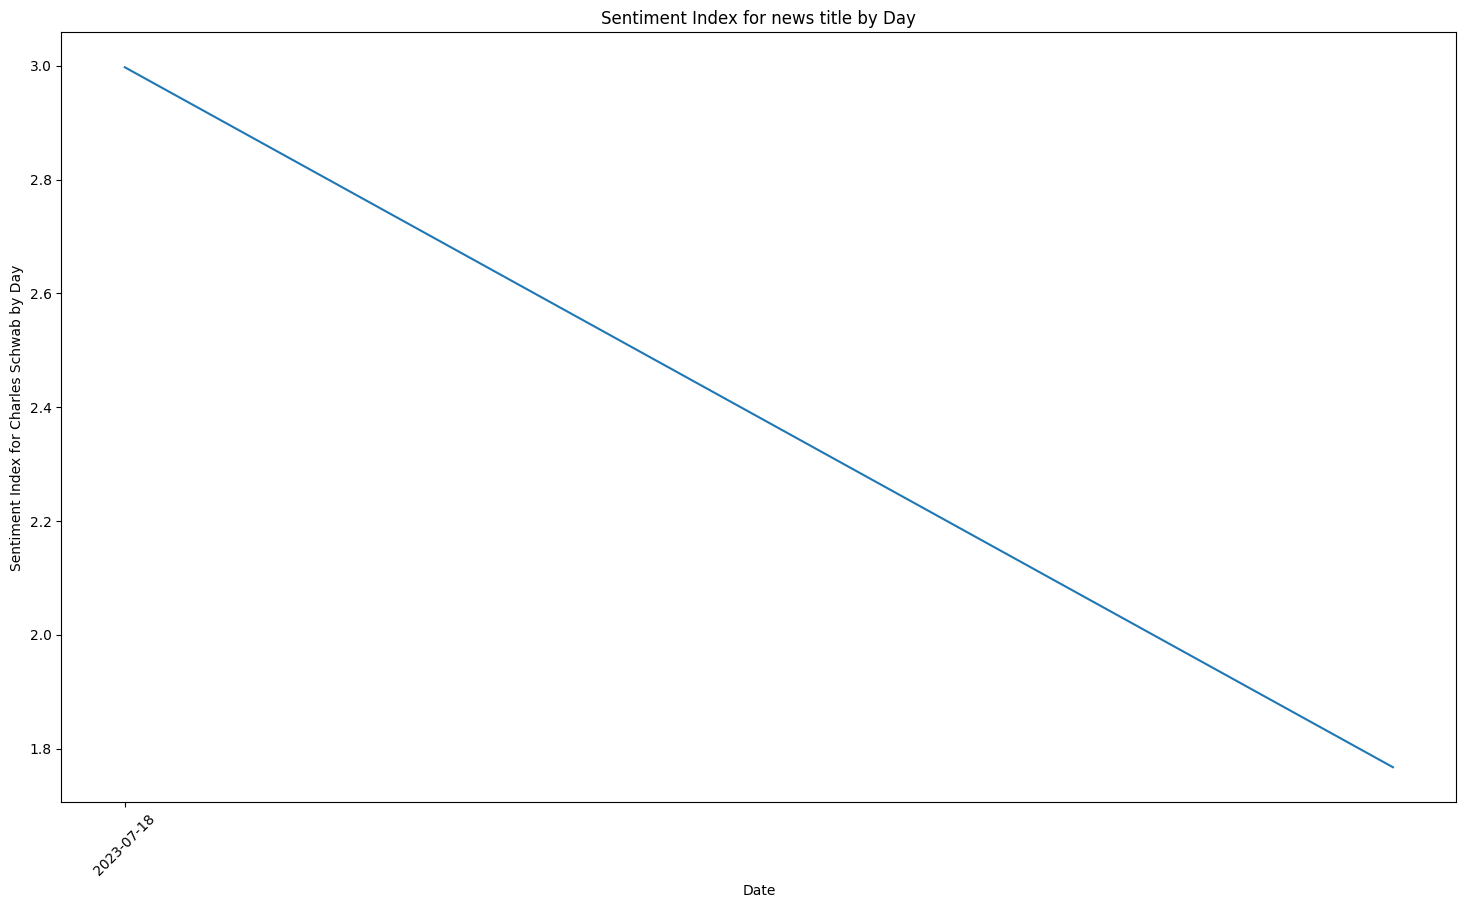

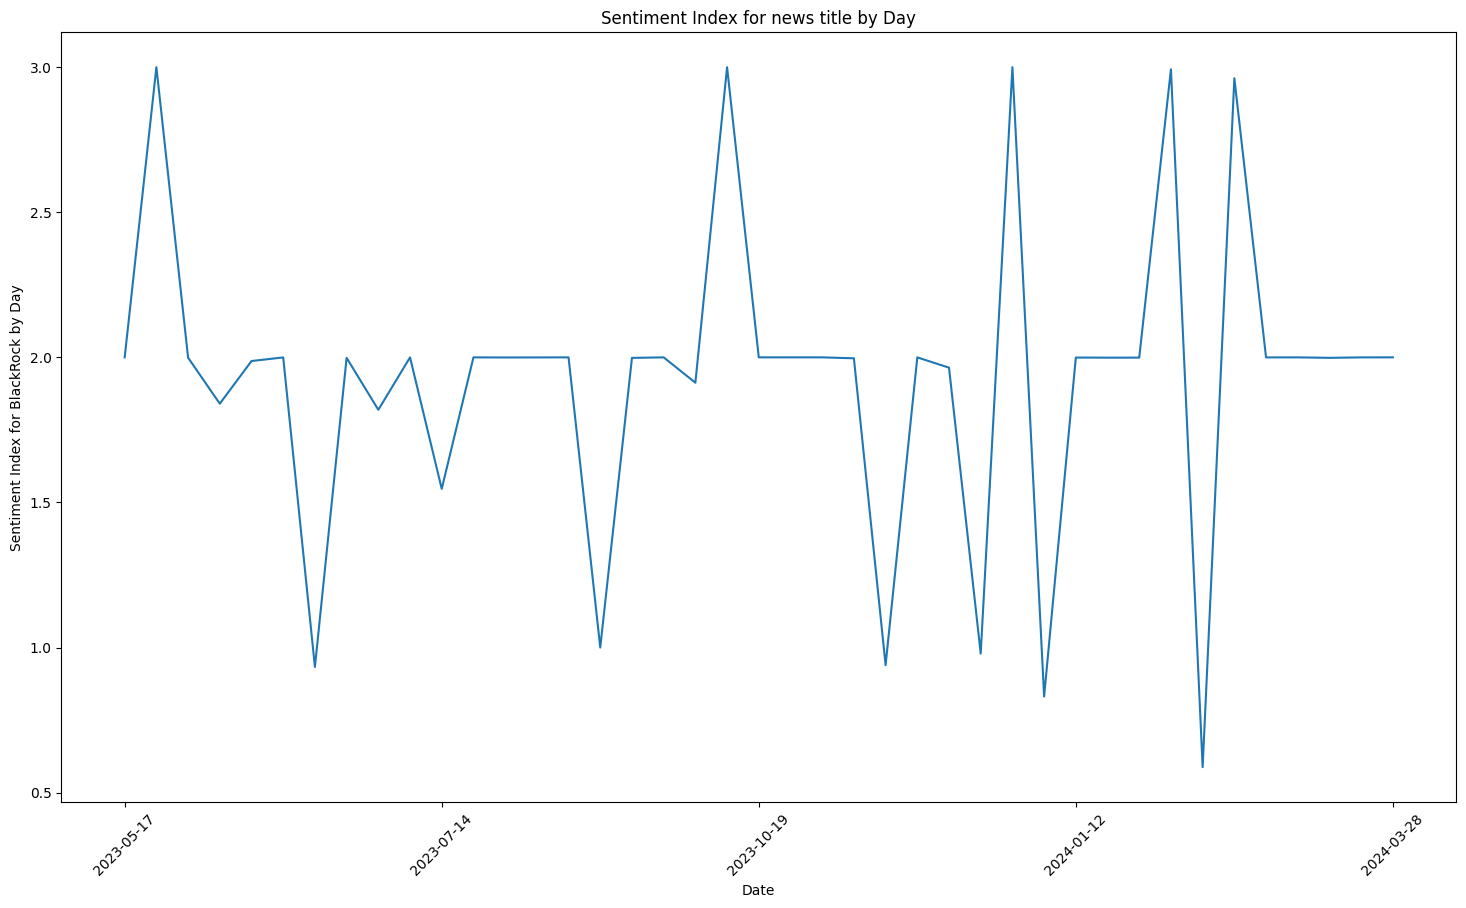

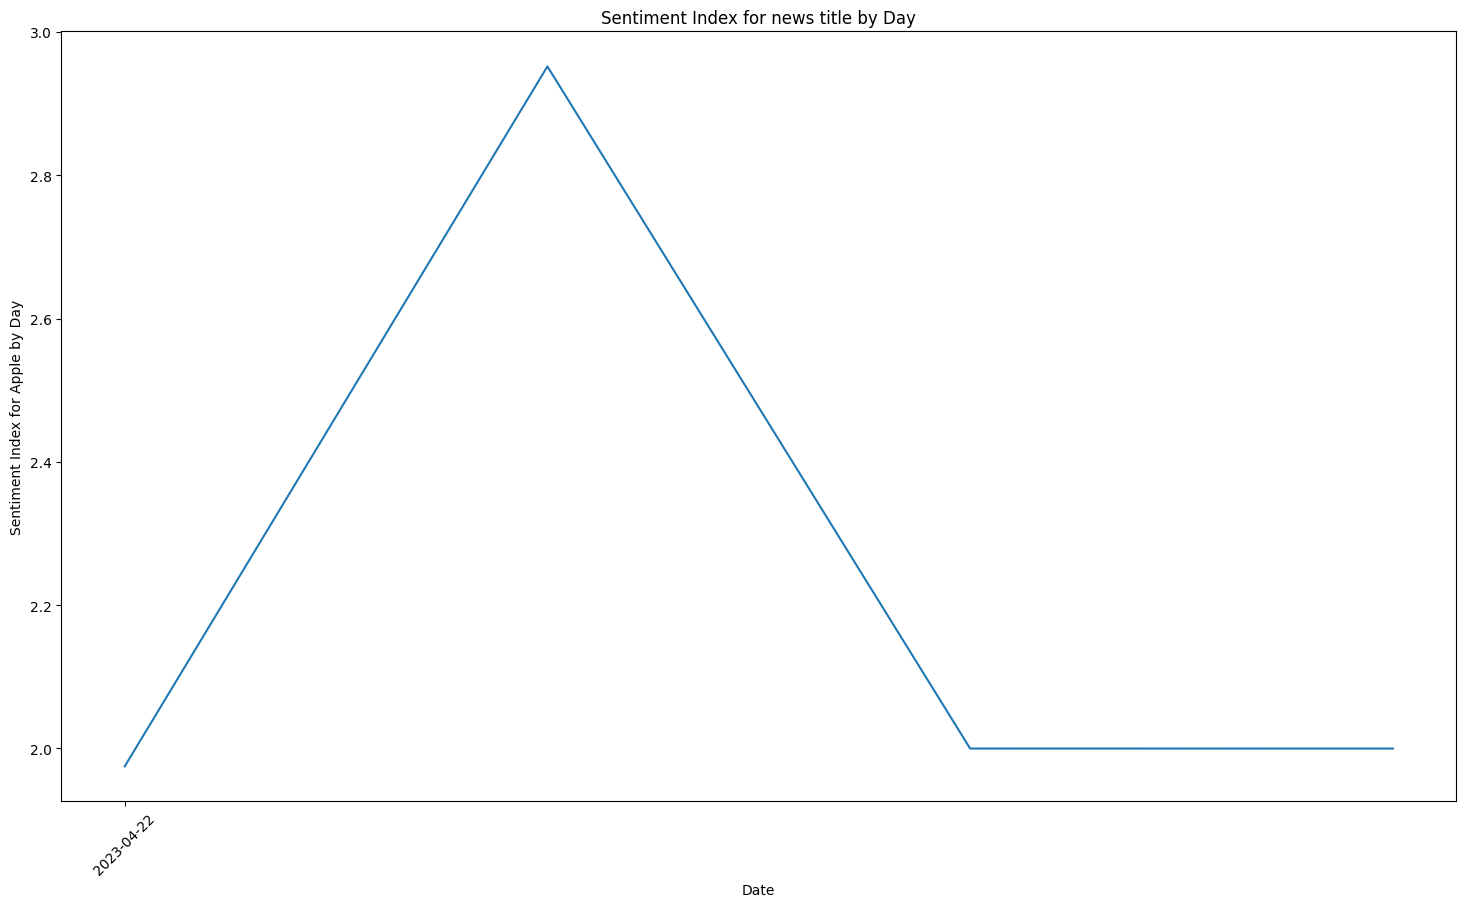

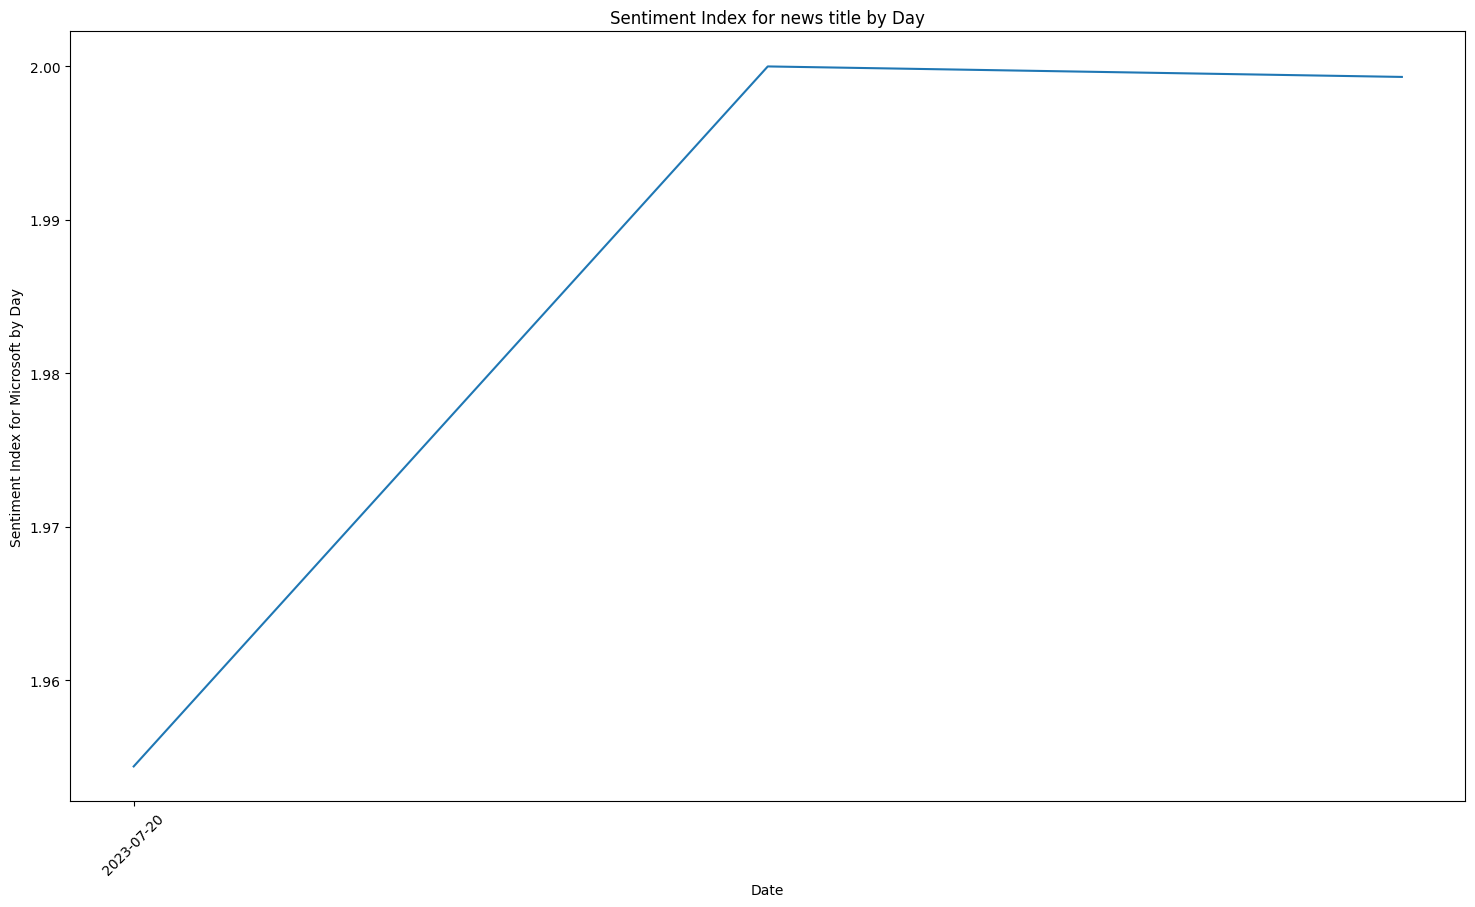

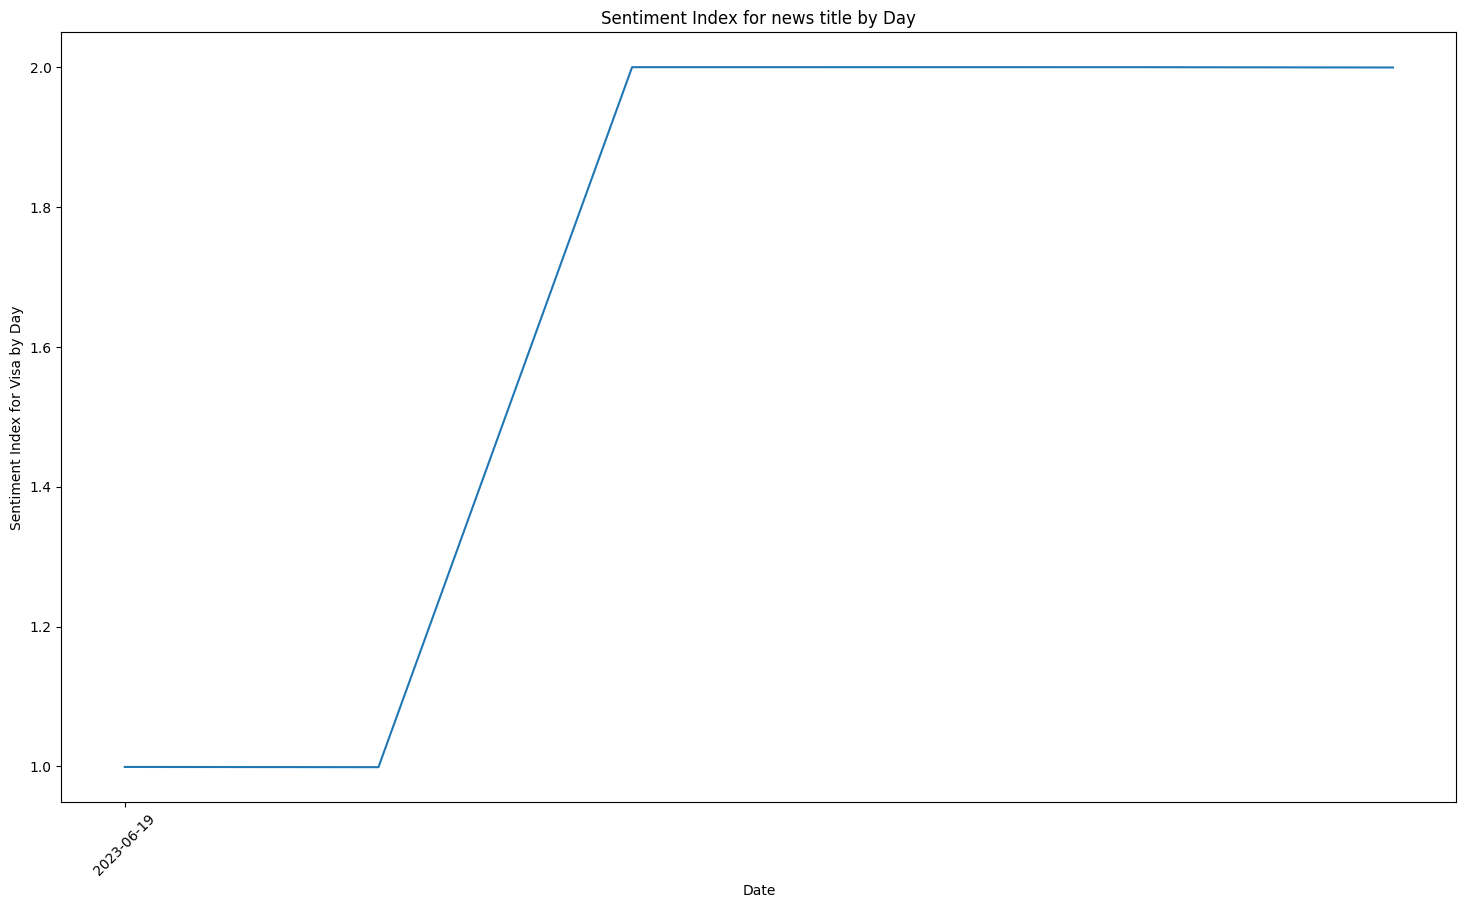

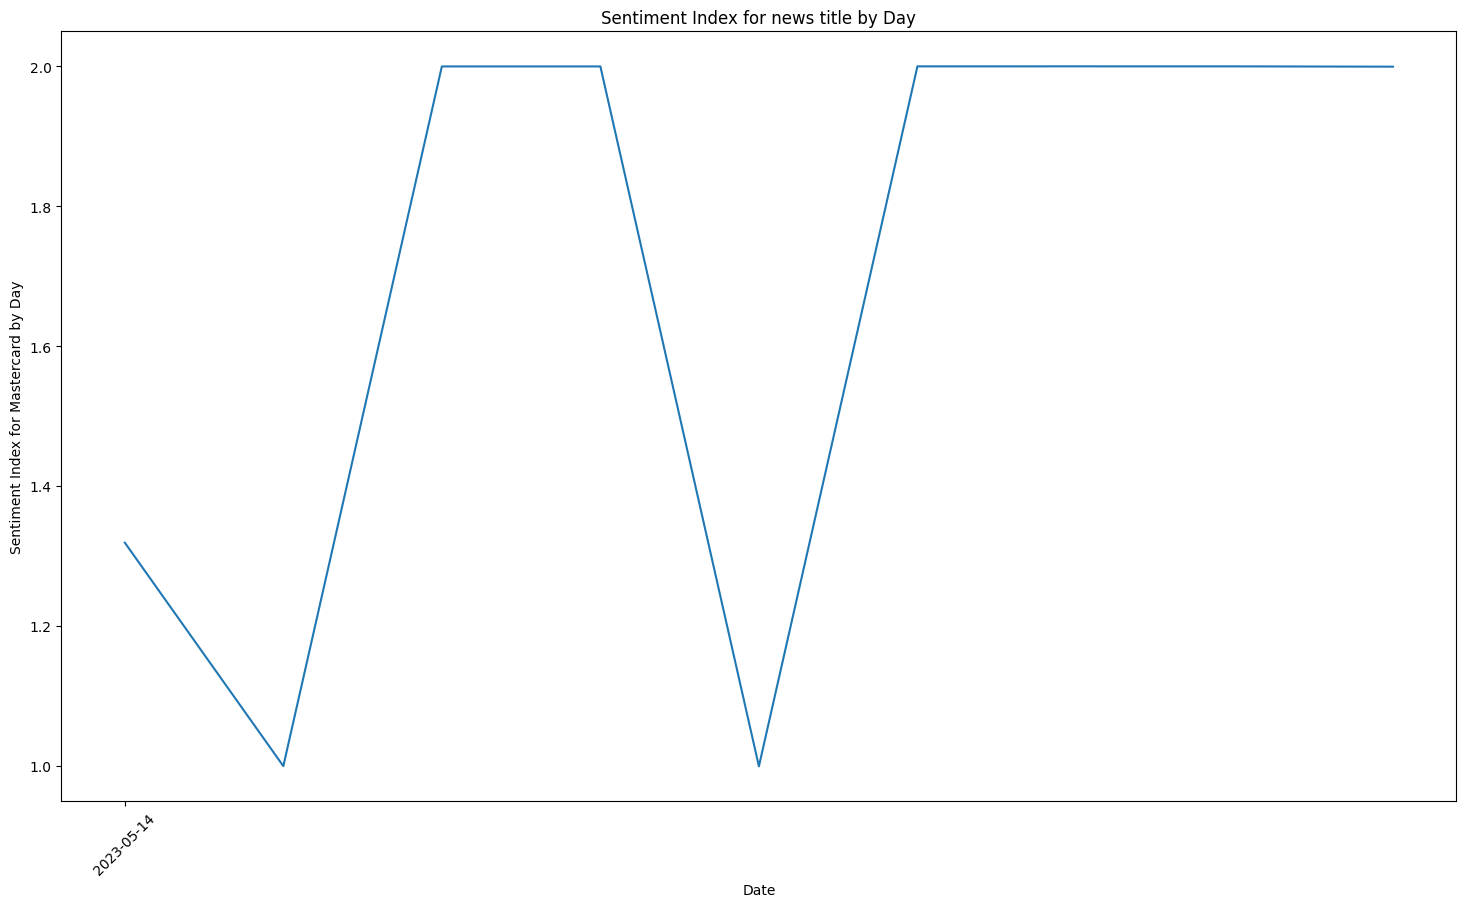

In [29]:
def companySentiment(name):
    sentiment_index_title_by_day = filtered_df[filtered_df['Title'].str.contains(name)].groupby('Date')['Sentiment_index'].mean()

    # Plotting the sentiment index by day
    plt.figure(figsize=(18, 10))
    plt.plot(sentiment_index_title_by_day.index, sentiment_index_title_by_day.values)
    plt.xlabel('Date')
    plt.ylabel('Sentiment Index for ' + name + ' by Day')
    plt.title('Sentiment Index for news title by Day')
    plt.xticks(rotation=45)
    plt.xticks(range(0, len(sentiment_index_title_by_day.index), 10), sentiment_index_title_by_day.index[::10])
    plt.show()


for i in processedCompanyList:
    companySentiment(i)